## Цели и задачи проекта

Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
чтобы на ранней стадии выявлять студентов, находящихся в группе риска

## Поэтапное описание работы

1. Импорт библиотек для анализа и чтение файла
2. Переименование полей и подготовка данных
3. Изучить каждое поле:
    1. Посмотреть на данные.
    2. Проверить данные на пустые значения.
    3. Проверить данные на дублированные/полностью скоррелированные значения.
    4. Проверить данные на наличие выбросов.
    5. Отобрать данные, пригодные для дальнейшего построения модели.
4. Провести кореляционный анализ
5. Провести анализ номинативных переменных

### 1. Импортируем нужные для чтения и первичного анализа библиотеки и прочитаем файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Здесь будем держать полезные функции

In [2]:
UNKNOWN = 'unknown'


def change_none(column):
    stud_math[column] = stud_math[column].apply(
        lambda x: None if (pd.isna(x) is True or str(x).strip() == '') else x
    )


def change_rate(column):
    stud_math[column] = stud_math[column].apply(
        lambda x: None if (x < 0 or x > 5) else x
    )


def change_bool(column):
    stud_math[column] = stud_math[column].apply(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else None
    )


def display_unique_and_counts(column):
    display(stud_math[column].unique())
    display(pd.DataFrame(stud_math[column].value_counts()))


def show_boxplot(x_column, y_column='score'):
    fig, ax = plt.subplots(figsize=(14, 4))
    data = stud_math.loc[stud_math.loc[:, x_column].isin(
        stud_math.loc[:, x_column].value_counts().index[:10]
    )]
    sns.boxplot(
        x=x_column,
        y=y_column,
        data=data,
        ax=ax
    )
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + x_column)
    plt.show()


def test_student(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        t_test_stud_math = ttest_ind(
            stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
            stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']
        )
        # Take into account the Bonferroni amendment
        if t_test_stud_math.pvalue <= 0.05 / len(combinations_all):
            print('Found statistically significant differences for the column', column)
            break


def set_value_if_nan(value, default):
    if math.isnan(value):
        return default
    return value


def set_value_if_none(value, default):
    if value is None:
        return default
    return value


def set_unknown_if_none(value):
    return set_value_if_none(value, UNKNOWN)


def job_str(job):
    valid_jobs = [
        'teacher',
        'health',
        'services',
        'at_home',
        'other'
    ]
    if job in valid_jobs:
        return job

    return UNKNOWN

### 2. Переименуем все столбцы для удобной работы

In [3]:
stud_math.columns = [
    'school',
    'sex',
    'age',
    'address_type',
    'family_size',
    'parents_status',
    'education_mother',
    'education_father',
    'job_mother',
    'job_father',
    'school_reason',
    'guardian',
    'travel_time',
    'study_time',
    'failures_count',
    'is_school_support',
    'is_family_support',
    'is_additional_math_classes',
    'is_additional_activities',
    'is_nursery',
    'study_time_granular',
    'is_high_school',
    'is_internet',
    'is_romantic',
    'family_rate',
    'free_time_rate',
    'go_out_rate',
    'health_rate',
    'absences',
    'score'
]

Заменим все пустые значения на None

In [4]:
for col in stud_math.columns:
    change_none(col)

display(stud_math.head(10))
stud_math.info()

,school,sex,age,address_type,family_size,parents_status,education_mother,education_father,job_mother,job_father,school_reason,guardian,travel_time,study_time,failures_count,is_school_support,is_family_support,is_additional_math_classes,is_additional_activities,is_nursery,study_time_granular,is_high_school,is_internet,is_romantic,family_rate,free_time_rate,go_out_rate,health_rate,absences,score
0,GP,F,18,U,None,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,None,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,None,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,None,no,yes,-6.0,yes,yes,None,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,None,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,None,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,None,None,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   school                      395 non-null    object 
 1   sex                         395 non-null    object 
 2   age                         395 non-null    int64  
 3   address_type                378 non-null    object 
 4   family_size                 368 non-null    object 
 5   parents_status              350 non-null    object 
 6   education_mother            392 non-null    float64
 7   education_father            371 non-null    float64
 8   job_mother                  376 non-null    object 
 9   job_father                  359 non-null    object 
 10  school_reason               378 non-null    object 
 11  guardian                    364 non-null    object 
 12  travel_time                 367 non-null    float64
 13  study_time                  388 non

Заменим во всех да / нет столбцах значения на 1 / 0 так машина будет лучше их "понимать"

In [5]:
yes_no_columns = [
    'is_school_support',
    'is_family_support',
    'is_additional_math_classes',
    'is_additional_activities',
    'is_nursery',
    'is_high_school',
    'is_internet',
    'is_romantic'
]

for col in yes_no_columns:
    change_bool(col)

Провалидируем все оценочные поля, заменив невалидные значения None

In [6]:
rate_columns = [
    'family_rate',
    'free_time_rate',
    'go_out_rate',
    'health_rate',
]

for col in rate_columns:
    change_rate(col)

## 3. Рассмотрим все столбцы по отлельности

#### Столбец score - баллы по госэкзамену по математике

Это столбец является важнейшим для работы модели, поэтому его нужно рассмотреть первым.

Удаляем строки с пустыми score, так как для обучения строки
без целевого значения использовать нельзя

In [7]:
stud_math.dropna(subset=['score'], inplace=True)

Проверим визуально данные score

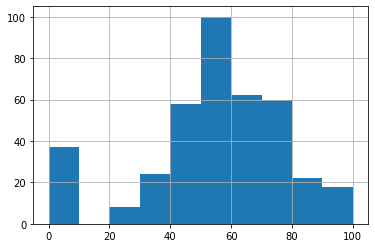

In [8]:
stud_math['score'].hist()

График показывает, что у нас многие получили оценки 0,
дальше никто не получил 10 баллов, что наводит на мысль, что 0 это
когда ученик не явился на экзамен или ошибка.
Нам необходимо научить машину чтобы предсказать оценку ученика а не то,
что он не явился на экзамен, поэтому можно эти значения также исключить

In [9]:
stud_math = stud_math.loc[stud_math['score'] > 0]

Смотрим на график снова

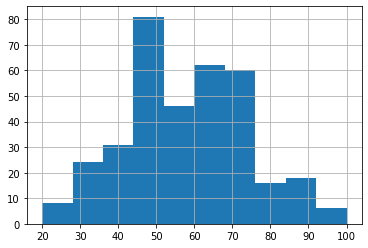

In [10]:
stud_math['score'].hist()

Теперь эти данные можно использовать

#### Столбец school - аббревиатура школы, в которой учится ученик

In [11]:
display_unique_and_counts('school')

array(['GP', 'MS'], dtype=object)

,school
GP,311
MS,41


##### Выводы по столбцу school:
1. Рассмартивается всего две школы.
2. Пустых значений нет.

#### Столбец sex - пол ученика ('F' - женский, 'M' - мужской)

In [12]:
display_unique_and_counts('sex')

array(['F', 'M'], dtype=object)

,sex
F,182
M,170


Мы будем использовать столбец на графиках, лучше сделать название информативными.
Переименуем F => female, M - male

In [13]:
stud_math['sex'] = stud_math['sex'].apply(
    lambda x: 'male' if x == 'M' else 'female' if x == 'F' else x
)

display_unique_and_counts('sex')

array(['female', 'male'], dtype=object)

,sex
female,182
male,170


##### Выводы по полю sex:
1. Пустых значений нет.
2. Соотношение мальчиков и девочек примерно равно, девочек немного больше

#### Столбец age - возраст ученика (от 15 до 22)

array([18, 17, 15, 16, 19, 22, 20, 21], dtype=int64)

,age
16,96
17,90
15,76
18,69
19,16
20,3
22,1
21,1


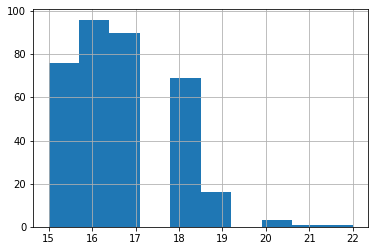

In [14]:
display_unique_and_counts('age')
stud_math['age'].hist()

##### Выводы по столбцу age:
1. Пустых значений нет.
2. Большинство респондентов дети 15-18 лет
3. Учеников 20-22 лет слишком мало для анализа, поэтому их можно отфильтровать

Удаляем данные респондентов старше 19 лет

In [15]:
stud_math = stud_math.loc[stud_math['age'] < 20]

#### Столбец address_type - тип адреса ученика ('U' - городской, 'R' - за городом)

In [16]:
display_unique_and_counts('address_type')

array(['U', None, 'R'], dtype=object)

,address_type
U,262
R,72


##### Выводы по столбцу address_type:
1. Имеются пустые значения
2. Большинство учеников городские

Заменим пропуски городскими т.к. пропусков очень мало

In [17]:
stud_math['address_type'] = stud_math['address_type'].apply(
    lambda x: 'U' if x is None else x
)

Сделаем столбцы более информативными

In [18]:
stud_math['address_type'] = stud_math['address_type'].apply(
    lambda x: 'urban' if x == 'U' else 'country' if x == 'R' else 'unknown'
)

In [19]:
display_unique_and_counts('address_type')

array(['urban', 'country'], dtype=object)

,address_type
urban,275
country,72


#### Столбец family_size - размер семьи('LE3' <= 3, 'GT3' >3)

In [20]:
display_unique_and_counts('family_size')

array([None, 'GT3', 'LE3'], dtype=object)

,family_size
GT3,224
LE3,99


##### Выводы по столбцу family_size:
1. Имеются пустые значения
2. Большинство семей большие

Сделаем столбцы более информативными

In [21]:
stud_math['family_size'] = stud_math['family_size'].apply(
    lambda x: 'less or equals 3' if x == 'LE3' else 'greater than 3' if x == 'GT3' else 'unknown'
)

In [22]:
display_unique_and_counts('family_size')

array(['unknown', 'greater than 3', 'less or equals 3'], dtype=object)

,family_size
greater than 3,224
less or equals 3,99
unknown,24


#### Столбец parents_status - статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [23]:
display_unique_and_counts('parents_status')

array(['A', None, 'T'], dtype=object)

,parents_status
T,274
A,32


##### Выводы по столбцу parents_status:
1. Имеются пустые значения
2. Большинство семей полные

Сделаем столбцы более информативными

In [24]:
stud_math['parents_status'] = stud_math['parents_status'].apply(
    lambda x: 'apart' if x == 'A' else 'together' if x == 'T' else 'unknown'
)

In [25]:
display_unique_and_counts('parents_status')

array(['apart', 'unknown', 'together'], dtype=object)

,parents_status
together,274
unknown,41
apart,32


#### Столбец education_mother - образование матери
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [26]:
display_unique_and_counts('education_mother')

array([ 4.,  1.,  3.,  2., nan,  0.])

,education_mother
4.0,124
2.0,87
3.0,85
1.0,46
0.0,3


##### Выводы по столбцу education_mother:
1. Имеются пустые значения
2. Большинство матерей имеют высшее образование

#### Столбец education_father - образование отца
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [27]:
display_unique_and_counts('education_father')

array([ 4.,  1.,  2.,  3., 40., nan,  0.])

,education_father
2.0,91
3.0,89
4.0,80
1.0,63
0.0,2
40.0,1


##### Выводы по столбцу education_father:
1. Имеются пустые значения
2. Имеются выборосы (40, скорее всего опечатка)

In [28]:
stud_math['education_father'] = stud_math['education_father'].apply(
    lambda x: 4 if x == 40 else x if 0 <= x <= 4 else None
)

In [29]:
display_unique_and_counts('education_father')

array([ 4.,  1.,  2.,  3., nan,  0.])

,education_father
2.0,91
3.0,89
4.0,81
1.0,63
0.0,2


#### Столбец job_mother - работа матери
('teacher' - учитель, 'health' - сфера здравоохранения,
'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [30]:
display_unique_and_counts('job_mother')

array(['at_home', 'health', 'other', 'services', 'teacher', None],
      dtype=object)

,job_mother
other,114
services,87
teacher,51
at_home,49
health,29


##### Выводы по столбцу job_mother:
1. Имеются пустые значения
2. Большинство матерей - гос служащие

Проведем валидацию значений, невалидные значения пометим unknown

In [31]:
stud_math['job_mother'] = stud_math['job_mother'].apply(job_str)

In [32]:
display_unique_and_counts('job_mother')

array(['at_home', 'health', 'other', 'services', 'teacher', 'unknown'],
      dtype=object)

,job_mother
other,114
services,87
teacher,51
at_home,49
health,29
unknown,17


#### Столбец job_father - работа отца
('teacher' - учитель, 'health' - сфера здравоохранения,
'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [33]:
display_unique_and_counts('job_father')

array(['teacher', 'other', None, 'health', 'services', 'at_home'],
      dtype=object)

,job_father
other,173
services,87
teacher,26
health,15
at_home,14


##### Выводы по столбцу job_father:
1. Имеются пустые значения
2. Большинство отцов - гос служащие

Проведем валидацию значений, невалидные значения пометим unknown

In [34]:
stud_math['job_father'] = stud_math['job_father'].apply(job_str)

In [35]:
display_unique_and_counts('job_father')

array(['teacher', 'other', 'unknown', 'health', 'services', 'at_home'],
      dtype=object)

,job_father
other,173
services,87
unknown,32
teacher,26
health,15
at_home,14


#### Столбец school_reason - причина выбора школы
('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [36]:
stud_math['school_reason'] = stud_math['school_reason'].apply(
    set_unknown_if_none
)

In [37]:
display_unique_and_counts('school_reason')

array(['course', 'other', 'home', 'reputation', 'unknown'], dtype=object)

,school_reason
course,115
reputation,96
home,89
other,32
unknown,15


##### Выводы по столбцу school_reason:
1. Имеются пустые значения
2. Большинство выбрали школу из-за образовательной программы

#### Столбец guardian - опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [38]:
stud_math['guardian'] = stud_math['guardian'].apply(set_unknown_if_none)

In [39]:
display_unique_and_counts('guardian')

array(['mother', 'father', 'other', 'unknown'], dtype=object)

,guardian
mother,224
father,78
unknown,26
other,19


##### Выводы по столбцу guardian:
1. Имеются пустые значения
2. Большинство опекунов - матери

#### Столбец travel_time - время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [40]:
display_unique_and_counts('travel_time')

array([ 2.,  1.,  3., nan,  4.])

,travel_time
1.0,215
2.0,85
3.0,17
4.0,7


Большинство добираются до школы очень быстро, заполним пустые значения самыми популярными

In [41]:
stud_math['travel_time'] = stud_math['travel_time'].apply(
    set_value_if_nan,
    args=(1,)
)

##### Выводы по столбцу travel_time:
1. Имеются пустые значения
2. Большинство детей живут рядом со школами

#### Столбец study_time - время на учёбу помимо школы в неделю
(1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [42]:
display_unique_and_counts('study_time')

array([ 2.,  3.,  1., nan,  4.])

,study_time
2.0,172
1.0,87
3.0,57
4.0,24


Большинство занимаются по 2-5 часов, заполним пустые значения самыми популярными

In [43]:
stud_math['study_time'] = stud_math['study_time'].apply(
    set_value_if_nan,
    args=(2,)
)

In [44]:
display_unique_and_counts('study_time')

array([2., 3., 1., 4.])

,study_time
2.0,179
1.0,87
3.0,57
4.0,24


##### Выводы по столбцу study_time:
1. Имеются пустые значения
2. Большинство детей занимаются по 2-5 часов помимо школы

#### Столбец study_time_granular - без описания

Судя по всему это поле изменяется так же как study_time (умноженое на -3).
Мы бы могли восстановить пустые значения study_time, если бы имели значения в study_time_granular.
Но пустых значений study_time не имеет.
Поэтому мы можем удалить это поле.

In [45]:
stud_math.drop(['study_time_granular'], axis=1, inplace=True)

#### Столбец failures_count - количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [46]:
display_unique_and_counts('failures_count')

array([ 0.,  3., nan,  2.,  1.])

,failures_count
0.0,272
1.0,38
2.0,9
3.0,8


Большинство значений 0, заполним пустые значения самыми популярными

In [47]:
stud_math['failures_count'] = stud_math['failures_count'].apply(
    set_value_if_nan,
    args=(0,)
)

In [48]:
display_unique_and_counts('failures_count')

array([0., 3., 2., 1.])

,failures_count
0.0,292
1.0,38
2.0,9
3.0,8


##### Выводы по столбцу failures_count:
1. Имеются пустые значения
2. Довольно много детей имеют одну и более внеучебную неудачу

#### Столбец is_school_support - дополнительная образовательная поддержка (yes или no)

In [49]:
display_unique_and_counts('is_school_support')

array([ 1.,  0., nan])

,is_school_support
0.0,291
1.0,48


##### Выводы по столбцу is_school_support:
1. Имеются пустые значения
2. Есть те, кто берет доп. образовательную поддержку

#### Столбец is_family_support - семейная образовательная поддержка (yes или no)

In [50]:
display_unique_and_counts('is_family_support')

array([ 0.,  1., nan])

,is_family_support
1.0,194
0.0,117


##### Выводы по столбцу is_family_support:
1. Имеются пустые значения
2. Почти в два раза больше семей поддерживают своих детей чем не поддерживают

#### Столбец is_additional_math_classes - дополнительные платные занятия по математике (yes или no)

In [51]:
display_unique_and_counts('is_additional_math_classes')

array([ 0., nan,  1.])

,is_additional_math_classes
0.0,167
1.0,144


##### Выводы по столбцу is_additional_math_classes:
1. Имеются пустые значения
2. Примерно равное распределение по доп. занятиям математикой и без

#### Столбец is_additional_activities - дополнительные внеучебные занятия (yes или no)

In [52]:
display_unique_and_counts('is_additional_activities')

array([ 0.,  1., nan])

,is_additional_activities
1.0,171
0.0,164


##### Выводы по столбцу is_additional_activities:
1. Имеются пустые значения
2. Примерно равное распределение по доп. занятиям и без

#### Столбец is_nursery - посещал детский сад (yes или no)

In [53]:
display_unique_and_counts('is_nursery')

array([ 1.,  0., nan])

,is_nursery
1.0,270
0.0,65


##### Выводы по столбцу is_nursery:
1. Имеются пустые значения
2. Большинство ходило в детский сад

#### Столбец is_high_school - хочет получить высшее образование (yes или no)

In [54]:
display_unique_and_counts('is_high_school')

array([ 1., nan,  0.])

,is_high_school
1.0,317
0.0,12


##### Выводы по столбцу is_high_school:
1. Имеются пустые значения
2. Абсолютное большинство хочет получить высшее образование
3. Можно пустые значения заменить на 1

In [55]:
stud_math['is_high_school'] = stud_math['is_high_school'].apply(
    set_value_if_nan,
    args=(1,)
)

In [56]:
display_unique_and_counts('is_high_school')

array([1., 0.])

,is_high_school
1.0,335
0.0,12


#### Столбец is_internet - наличие интернета дома (yes или no)

In [57]:
display_unique_and_counts('is_internet')

array([nan,  1.,  0.])

,is_internet
1.0,272
0.0,46


##### Выводы по столбцу is_internet:
1. Имеются пустые значения
2. У многих учеников есть интернет

#### Столбец is_romantic - в романтических отношениях (yes или no)

In [58]:
display_unique_and_counts('is_romantic')

array([ 0., nan,  1.])

,is_romantic
0.0,216
1.0,102


##### Выводы по столбцу is_romantic:
1. Имеются пустые значения
2. Одна треть учеников в романтических отношениях

#### Столбец family_rate - семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [59]:
display_unique_and_counts('family_rate')

array([ 4.,  5.,  3., nan,  2.,  1.])

,family_rate
4.0,163
5.0,83
3.0,56
2.0,14
1.0,6


##### Выводы по столбцу family_rate:
1. Имеются пустые значения
2. У большинства учеников в семье хорошие отношения
3. Можем заменить пустые значения на хорошие (4)

In [60]:
stud_math['family_rate'] = stud_math['family_rate'].apply(
    set_value_if_nan,
    args=(4,)
)

In [61]:
display_unique_and_counts('family_rate')

array([4., 5., 3., 2., 1.])

,family_rate
4.0,188
5.0,83
3.0,56
2.0,14
1.0,6


#### Столбец free_time_rate - свободное время после школы (от 1 - очень мало до 5 - очень мого)

array([ 3.,  2.,  4.,  1.,  5., nan])

,free_time_rate
3.0,132
4.0,100
2.0,59
5.0,32
1.0,16


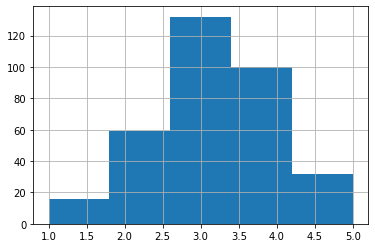

In [62]:
display_unique_and_counts('free_time_rate')
stud_math['free_time_rate'].hist(bins=5)

##### Выводы по столбцу free_time_rate:
1. Имеются пустые значения

#### Столбец go_out_rate - проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [63]:
display_unique_and_counts('go_out_rate')

array([ 4.,  3.,  2.,  1.,  5., nan])

,go_out_rate
3.0,115
2.0,92
4.0,73
5.0,42
1.0,19


##### Выводы по столбцу go_out_rate:
1. Имеются пустые значения

#### Столбец health_rate - текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

array([ 3.,  5.,  1.,  2.,  4., nan])

,health_rate
5.0,123
3.0,79
4.0,52
1.0,44
2.0,36


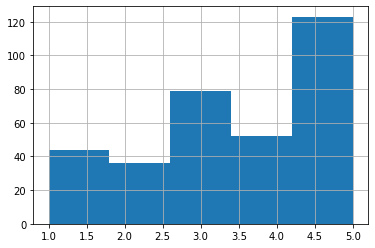

In [64]:
display_unique_and_counts('health_rate')
stud_math['health_rate'].hist(bins=5)

##### Выводы по столбцу health_rate:
1. Имеются пустые значения
2. Довольно много больных детей

#### Столбец absences - количество пропущенных занятий

count    337.000000
mean       7.513353
std       22.244327
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

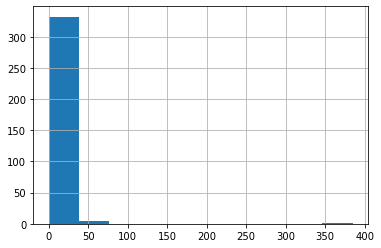

In [65]:
stud_math['absences'].hist()
stud_math['absences'].describe()

##### Выводы по столбцу absences:
1. Имеются пустые значения
2. Имеются выбросы нужно их отфильтровать

Воспользуемся формулой интерквартильного расстояния для фильтра выбросов

percentile 25: 2.0, percentile 75: 8.0, IQR: 6.0, Borders: [-7.0, 17.0].


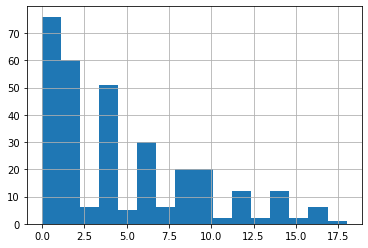

In [66]:
percentile_25 = stud_math['absences'].quantile(0.25)
percentile_75 = stud_math['absences'].quantile(0.75)
iqr = percentile_75 - percentile_25

print(
    'percentile 25: {},'.format(percentile_25),
    'percentile 75: {},'.format(percentile_75),
    'IQR: {},'.format(iqr),
    'borders: [{f}, {l}].'.format(
        f=percentile_25 - 1.5 * iqr,
        l=percentile_75 + 1.5 * iqr
    )
)

stud_math['absences'].loc[stud_math['absences'].between(percentile_25 - 1.5 * iqr, percentile_75 + 1.5 * iqr)].hist(
    bins=16,
    range=(0, 18),
    label='IQR'
)

Из графика видно, что можно отфильтровать все значения выходящие за границы от 0 до 18

In [67]:
stud_math['absences'] = stud_math['absences'].apply(
    lambda x: x if 0 <= x <= 18 else None
)

count    316.000000
mean       4.879747
std        4.668513
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       18.000000
Name: absences, dtype: float64

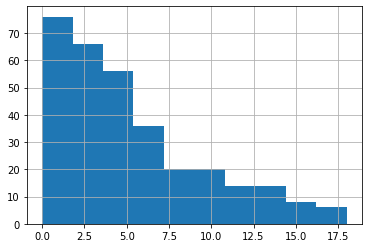

In [68]:
stud_math['absences'].hist()
stud_math['absences'].describe()

### Кореляционный анализ

In [69]:
corr = stud_math.corr()

Выводы:
1. Полностью скореллированных данных не наблюдается
2. Чем выше уровень образования матери (education_mother), тем выше уровень образования отца (education_father)
3. Уровень образования матери (education_mother) больше влияет на оценку за экзамен (score), чем уровень отца (education_father)
4. Наблюдается кореляция свободного времени (free_time_rate) и времени проведенного со сверстникамии (go_out_rate)
5. Чем больше поддержка семьи (is_family_support), тем больше доп. занятий по математике (is_additional_math_classes)
6. Доп. занятия математикой (is_additional_math_classes) и время на доп. занятия (study_time) связаны
7. Чем старше дети (age), тем чаще у них роматнические отношения (is_romantic)
8. Чем старше дети (age), тем больше у них пропущенных занятий (absences)
9. Оценка за экзамен (score) больше всего зависит от времени потраченного на доп. занятия (study_time)
10. Оценка за экзамен (score) имеет обратную корреляцию с ошибками (failures_count), доп. образования (is_school_support)
и пропусками (absences)

### Анализ номинативных переменных

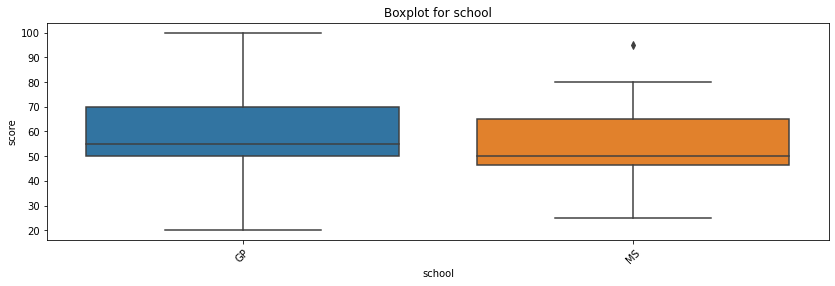

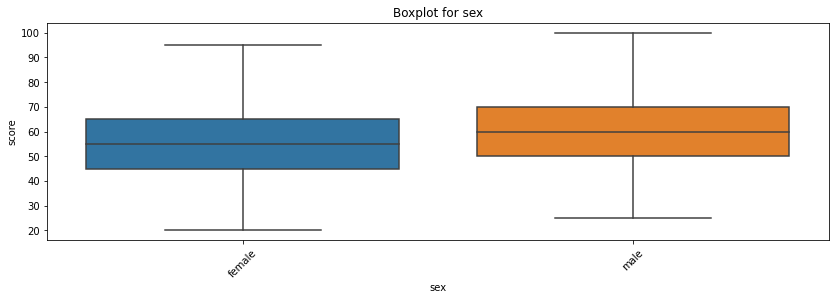

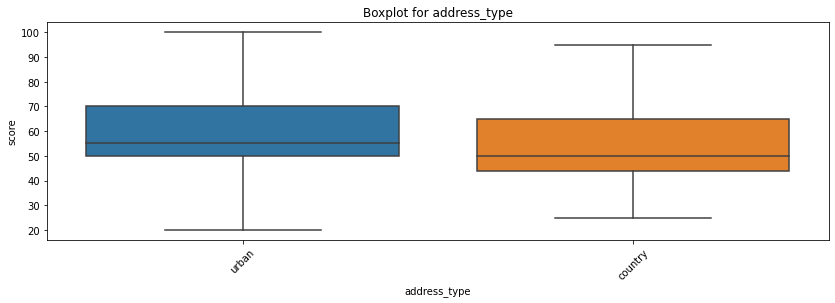

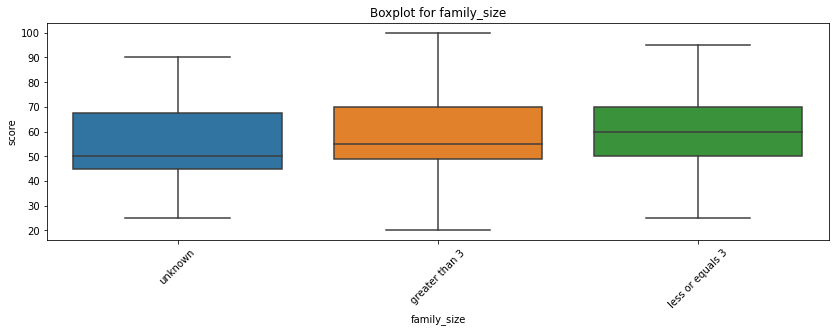

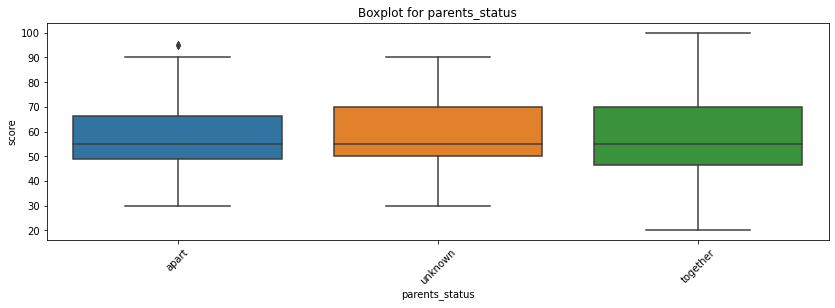

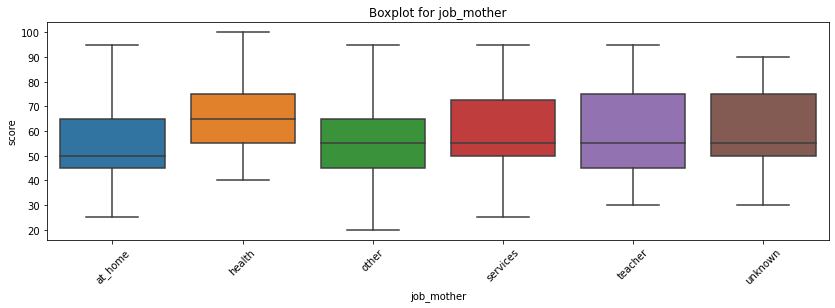

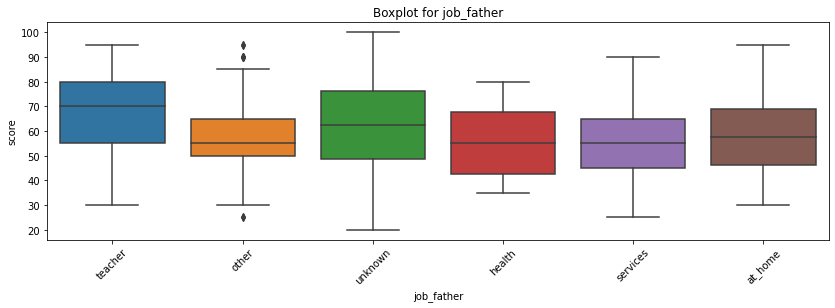

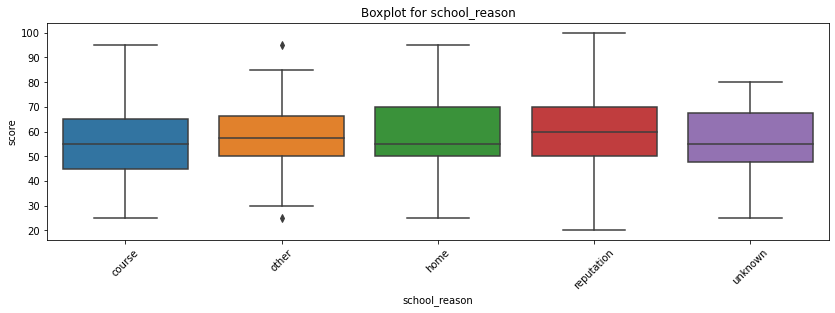

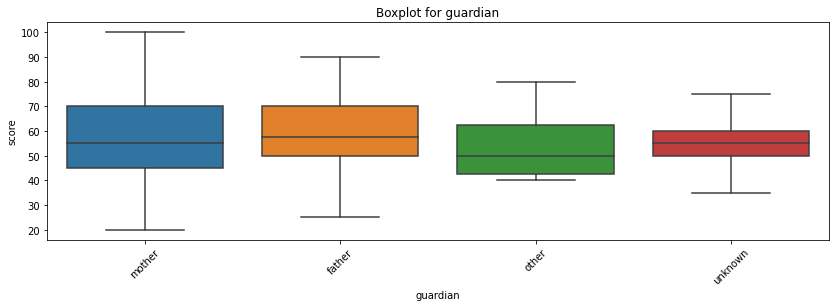

In [70]:
nominative_columns = [
    'school',
    'sex',
    'address_type',
    'family_size',
    'parents_status',
    'job_mother',
    'job_father',
    'school_reason',
    'guardian'
]

for col in nominative_columns:
    show_boxplot(col)

Выводы:
1. В школе GP лучше преподают математику
2. Мальчики лучше знают математику
3. Городские дети лучше сдают экзамен
4. В семье где больше детей, в среднем лучше с математикой
5. Статус родителей не очень влияет на оценку
6. Лучше знают математику дети у которых мама - медик
7. Лучше знают математику дети у которых папа - учитель
8. Выбор школы не очень влияет на оценку
9. Оценки лучше если есть мама или папа

Теперь проведем тест Стьюдента

In [71]:
important_nominative_columns = [
    'school',
    'sex',
    'address_type',
    'family_size',
    'job_mother',
    'job_father',
    'guardian'
]

for col in important_nominative_columns:
    test_student(col)

Found statistically significant differences for the column sex
Found statistically significant differences for the column address_type
Found statistically significant differences for the column job_father


Тест показал, что поля: пол (sex), тип адреса (address_type) и работа отца (job_father) важны для анализа

## Промежуточные выводы

По корреляционному анализу я бы взял поля: образование матери (education_mother), доп. время на обучение (study_time),
ошибки (failures_count), доп. образование (is_school_support) и пропуски (absences)

По анализу номинативных переменных я бы взял поля: пол (sex), тип адреса (address_type), работу отца (job_father)

## Основные итоги работы

Вывод: чтобы получить высокую оценку, нужно быть мальчиком, жить в городе, папа должен быть учителем, мама должна иметь
высшее образование, много доп. заниматься, мало ошибаться, не брать доп. образовательную поддержку
и присутствовать на всех занятиях.

В общем-то логично.

Итоговый датасет:

In [72]:
columns_for_model = [
    'sex',
    'address_type',
    'job_father',
    'education_mother',
    'study_time',
    'failures_count',
    'is_school_support',
    'absences'
]
stud_math_for_model = stud_math.loc[:, columns_for_model]
stud_math_for_model.head()

,sex,address_type,job_father,education_mother,study_time,failures_count,is_school_support,absences
0,female,urban,teacher,4.0,2.0,0.0,1.0,6.0
1,female,urban,other,1.0,2.0,0.0,0.0,4.0
2,female,urban,other,1.0,2.0,3.0,1.0,10.0
3,female,urban,unknown,4.0,3.0,0.0,0.0,2.0
4,female,urban,other,3.0,2.0,0.0,0.0,4.0


## Дополнительно: оставьте комментарий по своей работе для ментора

Возможно удаление пустых значений score было ошибкой и можно было заполнить например медианными значениями
предварительно сгруппировав по sex, address_type и job_father.

Также некоторые пустые значения я не заполнял из-за отсутствия данных.

Ещё у меня почему-то Pycharm не осилил столько строк и графиков.
Кончилась память и я вернулся на Jupiter через браузер.
